# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
import numpy as np

alpha = 0.2

In [93]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

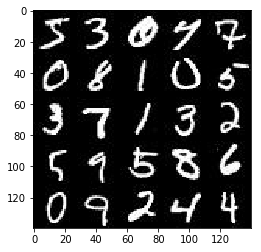

In [94]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

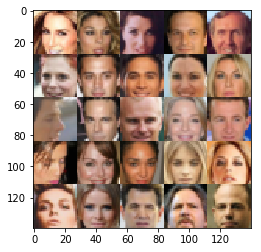

In [95]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [96]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [99]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [101]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, filters=64, kernel_size=4, strides=2, padding="SAME")
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = tf.maximum(alpha * conv1, conv1)

        conv2 = tf.layers.conv2d(conv1, filters=128, kernel_size=4, strides=2, padding="SAME")
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)

        conv3 = tf.layers.conv2d(conv2, filters=256, kernel_size=4, strides=2, padding="SAME")
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)

        features = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(features, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [102]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        z = tf.layers.dense(z, 4*4*512)
        z = tf.reshape(z, (-1, 4, 4, 512))
        z = tf.layers.batch_normalization(z, training=is_train)
        z = tf.maximum(alpha * z, z)
        
        conv1 = tf.layers.conv2d_transpose(z, filters=256, kernel_size=4, strides=1, padding="VALID")
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, filters=128, kernel_size=4, strides=2, padding="SAME")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d_transpose(conv2, filters=out_channel_dim, kernel_size=4, strides=2, padding="SAME")
        out = tf.tanh(conv3)

    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [103]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    
    smoothing_factor = np.random.uniform(0.8, 1.0)
    _, d_logits_real = discriminator(input_real, reuse=False)
    
    fake = generator(input_z, out_channel_dim, is_train=True)
    
    d_logits_fake = discriminator(fake, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * smoothing_factor))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [104]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_update_ops):
        g_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [105]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [109]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    i = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                i += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})
                
                if i % 50 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    print("Epoch {}/{} Iteration {}...".format(epoch_i+1, epoch_count, i), "Discriminator Loss: {:.4f}...".format(train_loss_d), "Generator Loss: {:.4f}".format(train_loss_g))   

                if i % 100 == 0:
                    show_generator_output(sess, n_images=25, input_z=input_z, out_channel_dim=data_shape[3], image_mode=data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Iteration 50... Discriminator Loss: 1.1922... Generator Loss: 1.4722
Epoch 1/2 Iteration 100... Discriminator Loss: 1.3651... Generator Loss: 0.8342


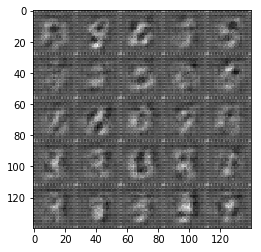

Epoch 1/2 Iteration 150... Discriminator Loss: 1.3511... Generator Loss: 0.9938
Epoch 1/2 Iteration 200... Discriminator Loss: 1.2674... Generator Loss: 1.0147


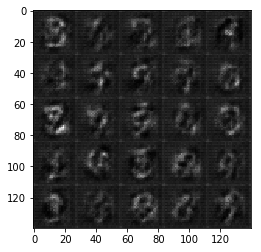

Epoch 1/2 Iteration 250... Discriminator Loss: 1.4163... Generator Loss: 0.3883
Epoch 1/2 Iteration 300... Discriminator Loss: 1.2948... Generator Loss: 0.4609


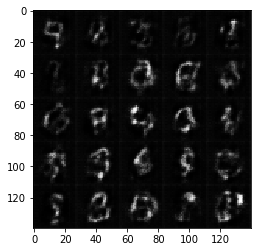

Epoch 1/2 Iteration 350... Discriminator Loss: 1.1659... Generator Loss: 1.3512
Epoch 1/2 Iteration 400... Discriminator Loss: 1.5722... Generator Loss: 0.3302


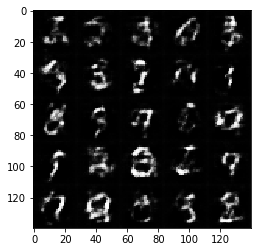

Epoch 1/2 Iteration 450... Discriminator Loss: 1.0625... Generator Loss: 0.8262
Epoch 1/2 Iteration 500... Discriminator Loss: 1.3939... Generator Loss: 0.4130


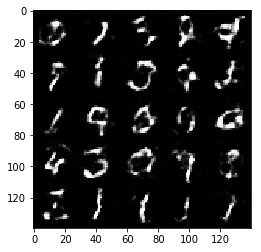

Epoch 1/2 Iteration 550... Discriminator Loss: 1.3222... Generator Loss: 0.9971
Epoch 1/2 Iteration 600... Discriminator Loss: 1.3125... Generator Loss: 0.4517


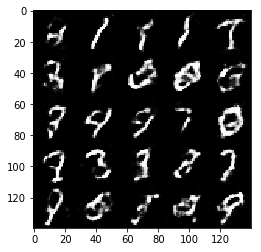

Epoch 1/2 Iteration 650... Discriminator Loss: 1.2960... Generator Loss: 0.8835
Epoch 1/2 Iteration 700... Discriminator Loss: 1.3515... Generator Loss: 1.0695


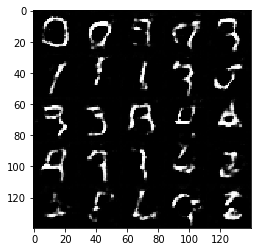

Epoch 1/2 Iteration 750... Discriminator Loss: 1.4592... Generator Loss: 0.3703
Epoch 1/2 Iteration 800... Discriminator Loss: 1.3814... Generator Loss: 0.4214


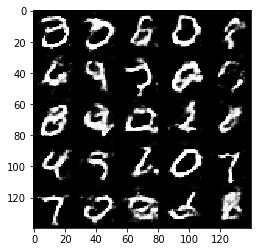

Epoch 1/2 Iteration 850... Discriminator Loss: 1.0938... Generator Loss: 0.6733
Epoch 1/2 Iteration 900... Discriminator Loss: 1.1617... Generator Loss: 1.0509


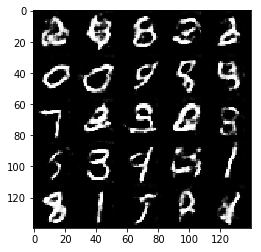

Epoch 2/2 Iteration 950... Discriminator Loss: 1.1554... Generator Loss: 0.6615
Epoch 2/2 Iteration 1000... Discriminator Loss: 1.1026... Generator Loss: 0.6502


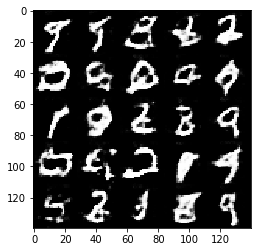

Epoch 2/2 Iteration 1050... Discriminator Loss: 1.1631... Generator Loss: 0.6277
Epoch 2/2 Iteration 1100... Discriminator Loss: 1.3808... Generator Loss: 0.4101


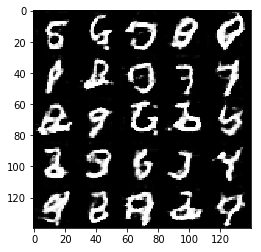

Epoch 2/2 Iteration 1150... Discriminator Loss: 1.1601... Generator Loss: 0.6441
Epoch 2/2 Iteration 1200... Discriminator Loss: 1.1652... Generator Loss: 0.5402


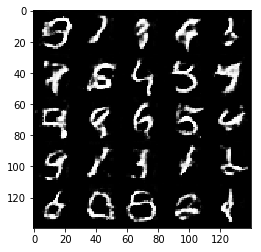

Epoch 2/2 Iteration 1250... Discriminator Loss: 1.1680... Generator Loss: 1.0540
Epoch 2/2 Iteration 1300... Discriminator Loss: 1.3594... Generator Loss: 1.2299


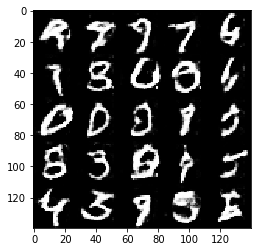

Epoch 2/2 Iteration 1350... Discriminator Loss: 1.4965... Generator Loss: 0.3644
Epoch 2/2 Iteration 1400... Discriminator Loss: 1.1446... Generator Loss: 0.9495


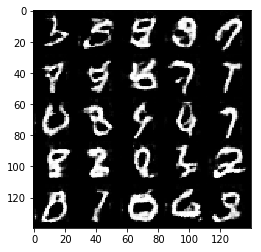

Epoch 2/2 Iteration 1450... Discriminator Loss: 0.9965... Generator Loss: 0.8386
Epoch 2/2 Iteration 1500... Discriminator Loss: 0.9111... Generator Loss: 1.0383


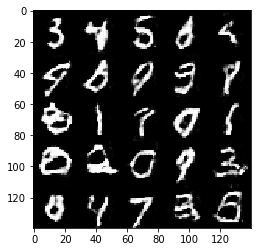

Epoch 2/2 Iteration 1550... Discriminator Loss: 1.0111... Generator Loss: 0.7403
Epoch 2/2 Iteration 1600... Discriminator Loss: 1.0808... Generator Loss: 0.6477


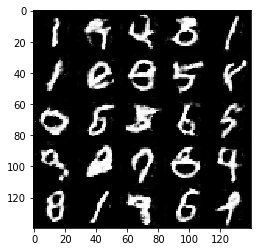

Epoch 2/2 Iteration 1650... Discriminator Loss: 0.8527... Generator Loss: 1.0829
Epoch 2/2 Iteration 1700... Discriminator Loss: 0.9777... Generator Loss: 0.7699


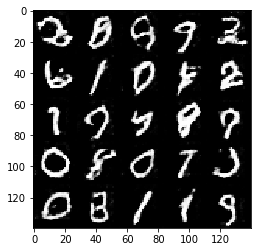

Epoch 2/2 Iteration 1750... Discriminator Loss: 1.0784... Generator Loss: 1.2428
Epoch 2/2 Iteration 1800... Discriminator Loss: 1.4741... Generator Loss: 0.3950


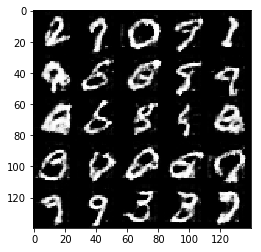

Epoch 2/2 Iteration 1850... Discriminator Loss: 1.1972... Generator Loss: 1.2495


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2 Iteration 50... Discriminator Loss: 0.9365... Generator Loss: 3.3404
Epoch 1/2 Iteration 100... Discriminator Loss: 1.5883... Generator Loss: 1.4829


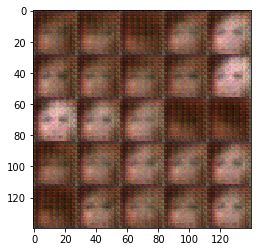

Epoch 1/2 Iteration 150... Discriminator Loss: 1.2497... Generator Loss: 1.4325
Epoch 1/2 Iteration 200... Discriminator Loss: 1.4743... Generator Loss: 0.4875


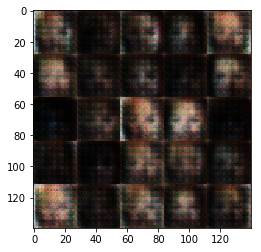

Epoch 1/2 Iteration 250... Discriminator Loss: 1.6697... Generator Loss: 0.3806
Epoch 1/2 Iteration 300... Discriminator Loss: 1.4471... Generator Loss: 1.1277


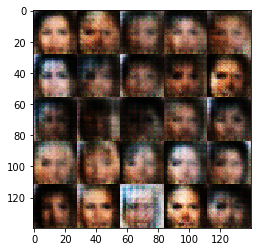

Epoch 1/2 Iteration 350... Discriminator Loss: 1.8303... Generator Loss: 1.2451
Epoch 1/2 Iteration 400... Discriminator Loss: 1.4562... Generator Loss: 0.6773


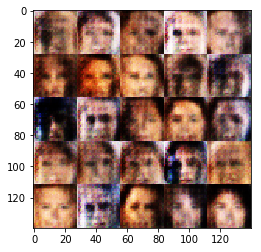

Epoch 1/2 Iteration 450... Discriminator Loss: 1.5196... Generator Loss: 0.4545
Epoch 1/2 Iteration 500... Discriminator Loss: 1.5200... Generator Loss: 0.5786


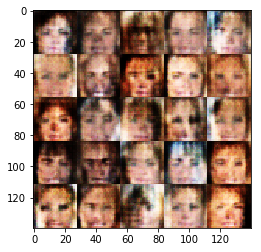

Epoch 1/2 Iteration 550... Discriminator Loss: 1.5334... Generator Loss: 0.4811
Epoch 1/2 Iteration 600... Discriminator Loss: 1.6297... Generator Loss: 0.6341


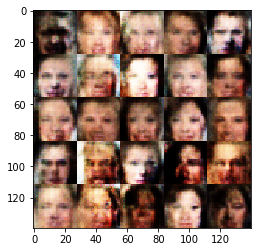

Epoch 1/2 Iteration 650... Discriminator Loss: 1.5642... Generator Loss: 0.5153
Epoch 1/2 Iteration 700... Discriminator Loss: 1.5861... Generator Loss: 0.5785


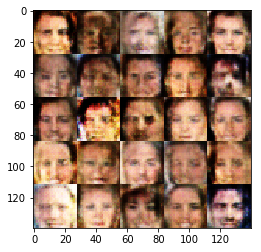

Epoch 1/2 Iteration 750... Discriminator Loss: 1.4930... Generator Loss: 0.6068
Epoch 1/2 Iteration 800... Discriminator Loss: 1.4257... Generator Loss: 0.9112


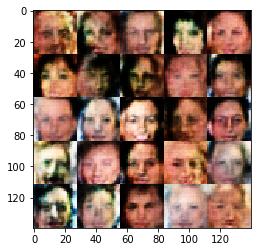

Epoch 1/2 Iteration 850... Discriminator Loss: 1.9404... Generator Loss: 1.1159
Epoch 1/2 Iteration 900... Discriminator Loss: 1.3956... Generator Loss: 0.5552


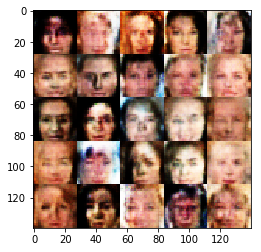

Epoch 1/2 Iteration 950... Discriminator Loss: 1.6608... Generator Loss: 0.3553
Epoch 1/2 Iteration 1000... Discriminator Loss: 1.2250... Generator Loss: 1.1784


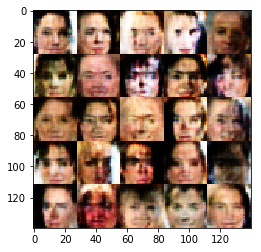

Epoch 1/2 Iteration 1050... Discriminator Loss: 1.1769... Generator Loss: 1.3467
Epoch 1/2 Iteration 1100... Discriminator Loss: 2.1262... Generator Loss: 0.2558


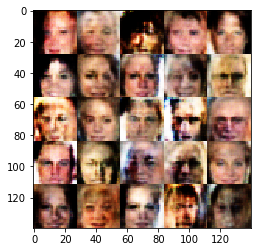

Epoch 1/2 Iteration 1150... Discriminator Loss: 1.1474... Generator Loss: 1.6433
Epoch 1/2 Iteration 1200... Discriminator Loss: 1.3266... Generator Loss: 0.5786


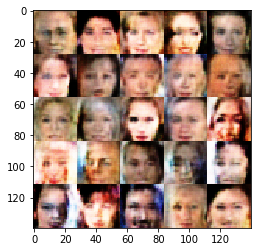

Epoch 1/2 Iteration 1250... Discriminator Loss: 1.2750... Generator Loss: 0.7950
Epoch 1/2 Iteration 1300... Discriminator Loss: 1.1951... Generator Loss: 1.2375


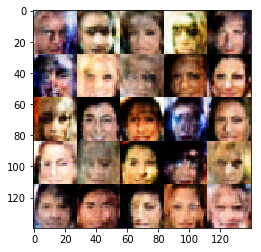

Epoch 1/2 Iteration 1350... Discriminator Loss: 1.3799... Generator Loss: 0.7623
Epoch 1/2 Iteration 1400... Discriminator Loss: 1.1849... Generator Loss: 0.9052


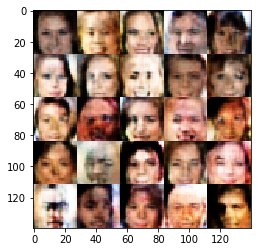

Epoch 1/2 Iteration 1450... Discriminator Loss: 1.3807... Generator Loss: 0.5383
Epoch 1/2 Iteration 1500... Discriminator Loss: 1.3150... Generator Loss: 0.5847


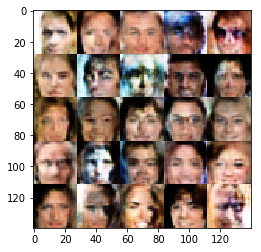

Epoch 1/2 Iteration 1550... Discriminator Loss: 1.1760... Generator Loss: 0.7426
Epoch 1/2 Iteration 1600... Discriminator Loss: 1.4854... Generator Loss: 0.4528


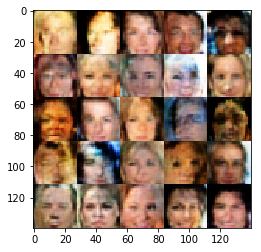

Epoch 1/2 Iteration 1650... Discriminator Loss: 1.1889... Generator Loss: 0.8866
Epoch 1/2 Iteration 1700... Discriminator Loss: 1.3538... Generator Loss: 1.4805


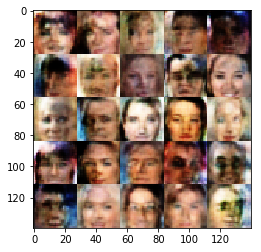

Epoch 1/2 Iteration 1750... Discriminator Loss: 1.3597... Generator Loss: 0.6760
Epoch 1/2 Iteration 1800... Discriminator Loss: 1.1278... Generator Loss: 0.8211


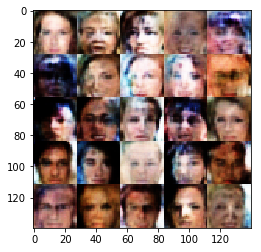

Epoch 1/2 Iteration 1850... Discriminator Loss: 1.1114... Generator Loss: 0.8194
Epoch 1/2 Iteration 1900... Discriminator Loss: 1.0432... Generator Loss: 1.2743


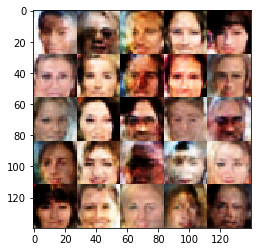

Epoch 1/2 Iteration 1950... Discriminator Loss: 1.5024... Generator Loss: 0.4593
Epoch 1/2 Iteration 2000... Discriminator Loss: 2.0779... Generator Loss: 1.8979


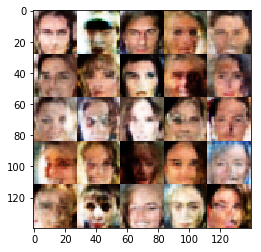

Epoch 1/2 Iteration 2050... Discriminator Loss: 1.2304... Generator Loss: 1.1205
Epoch 1/2 Iteration 2100... Discriminator Loss: 1.1896... Generator Loss: 1.4063


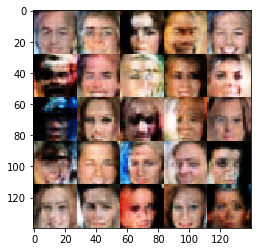

Epoch 1/2 Iteration 2150... Discriminator Loss: 1.4180... Generator Loss: 1.0639
Epoch 1/2 Iteration 2200... Discriminator Loss: 1.1951... Generator Loss: 0.7789


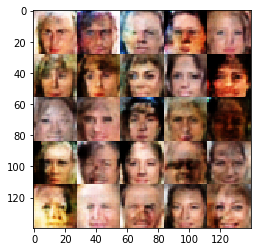

Epoch 1/2 Iteration 2250... Discriminator Loss: 1.3166... Generator Loss: 0.5829
Epoch 1/2 Iteration 2300... Discriminator Loss: 1.0306... Generator Loss: 0.9823


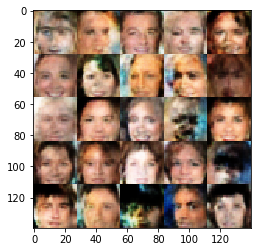

Epoch 1/2 Iteration 2350... Discriminator Loss: 1.5923... Generator Loss: 1.0786
Epoch 1/2 Iteration 2400... Discriminator Loss: 1.2572... Generator Loss: 0.6543


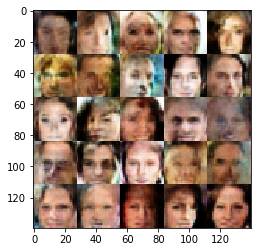

Epoch 1/2 Iteration 2450... Discriminator Loss: 1.2466... Generator Loss: 0.6499
Epoch 1/2 Iteration 2500... Discriminator Loss: 1.0607... Generator Loss: 0.9106


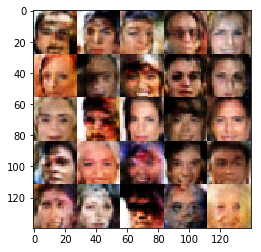

Epoch 1/2 Iteration 2550... Discriminator Loss: 1.0982... Generator Loss: 1.4089
Epoch 1/2 Iteration 2600... Discriminator Loss: 1.1232... Generator Loss: 0.8356


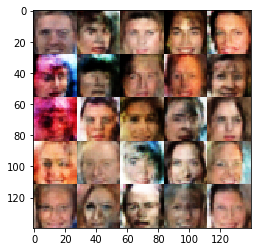

Epoch 1/2 Iteration 2650... Discriminator Loss: 1.0130... Generator Loss: 1.0517
Epoch 1/2 Iteration 2700... Discriminator Loss: 0.9386... Generator Loss: 1.2012


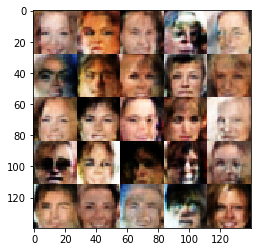

Epoch 1/2 Iteration 2750... Discriminator Loss: 1.1671... Generator Loss: 1.3769
Epoch 1/2 Iteration 2800... Discriminator Loss: 0.9945... Generator Loss: 1.0676


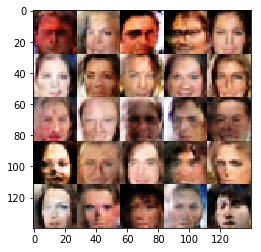

Epoch 1/2 Iteration 2850... Discriminator Loss: 1.0914... Generator Loss: 1.2114
Epoch 1/2 Iteration 2900... Discriminator Loss: 1.2102... Generator Loss: 1.0439


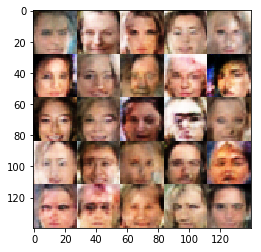

Epoch 1/2 Iteration 2950... Discriminator Loss: 1.2983... Generator Loss: 1.1989
Epoch 1/2 Iteration 3000... Discriminator Loss: 1.2283... Generator Loss: 0.7530


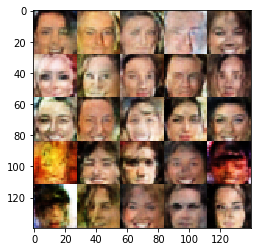

Epoch 1/2 Iteration 3050... Discriminator Loss: 1.1800... Generator Loss: 1.6714
Epoch 1/2 Iteration 3100... Discriminator Loss: 0.9903... Generator Loss: 1.5209


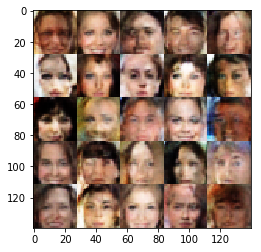

Epoch 1/2 Iteration 3150... Discriminator Loss: 2.2096... Generator Loss: 0.2532
Epoch 2/2 Iteration 3200... Discriminator Loss: 1.2344... Generator Loss: 0.6624


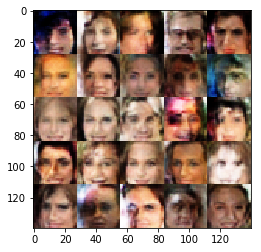

Epoch 2/2 Iteration 3250... Discriminator Loss: 1.9303... Generator Loss: 1.3479
Epoch 2/2 Iteration 3300... Discriminator Loss: 1.0490... Generator Loss: 1.0110


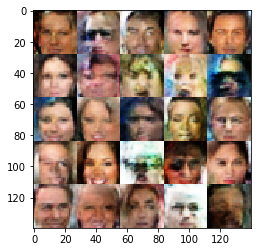

Epoch 2/2 Iteration 3350... Discriminator Loss: 1.0520... Generator Loss: 1.6307
Epoch 2/2 Iteration 3400... Discriminator Loss: 1.7142... Generator Loss: 0.3839


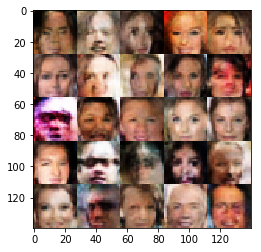

Epoch 2/2 Iteration 3450... Discriminator Loss: 1.1774... Generator Loss: 1.7029
Epoch 2/2 Iteration 3500... Discriminator Loss: 0.9691... Generator Loss: 1.3099


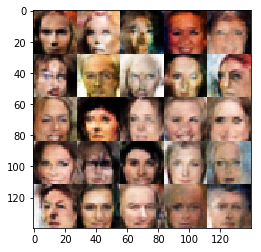

Epoch 2/2 Iteration 3550... Discriminator Loss: 1.2511... Generator Loss: 1.3188
Epoch 2/2 Iteration 3600... Discriminator Loss: 0.8554... Generator Loss: 1.9139


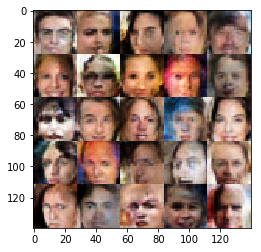

Epoch 2/2 Iteration 3650... Discriminator Loss: 1.1013... Generator Loss: 0.8438
Epoch 2/2 Iteration 3700... Discriminator Loss: 1.0676... Generator Loss: 0.9479


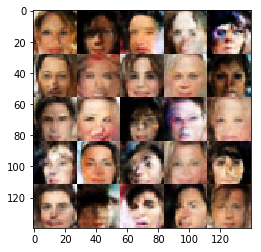

Epoch 2/2 Iteration 3750... Discriminator Loss: 0.9486... Generator Loss: 1.2335
Epoch 2/2 Iteration 3800... Discriminator Loss: 0.9359... Generator Loss: 1.2454


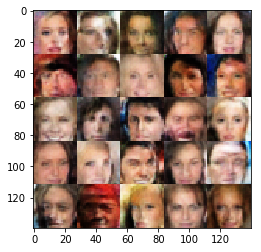

Epoch 2/2 Iteration 3850... Discriminator Loss: 1.1329... Generator Loss: 1.8556
Epoch 2/2 Iteration 3900... Discriminator Loss: 0.9784... Generator Loss: 1.1304


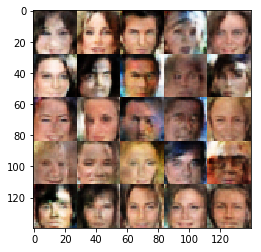

Epoch 2/2 Iteration 3950... Discriminator Loss: 1.3962... Generator Loss: 0.5716


In [ ]:
batch_size = 64
z_dim = 200
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.